In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

In [3]:
def generate_trainingdata(train_dir, tgt_img_size):
  '''
  Desc: Function for image augmentation of training data
  Parameters:
            train_dir: directory in which training images are available
            tgt_img_size: target image size which is needed in output
  Returns:
          train_generator: data of augmented images which is to be used as i/p
  '''
  train_datagen = ImageDataGenerator(rescale=1. / 255.0,
                                    horizontal_flip = False, 
                                    vertical_flip = False,
                                    height_shift_range= 0.2, 
                                    width_shift_range=0.2, 
                                    rotation_range=45, 
                                    shear_range = 0.2,
                                    zoom_range=0.25)
  train_generator = train_datagen.flow_from_directory(train_dir,
                                                      batch_size=20,
                                                      class_mode='binary',
                                                      target_size=tgt_img_size)
  return train_generator


def generate_validationdata(validation_dir, tgt_img_size):
  '''
  Desc: Function for image augmentation of validation data
  Parameters:
            validation_dir: directory in which test images are available
            tgt_img_size: target image size which is needed in output
  Returns:
          validation_generator: data of augmented images which is to be used
                                to test the model
  '''
  test_datagen = ImageDataGenerator(rescale = 1.0/255.)
  validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                          batch_size = 20,
                                                          class_mode = 'binary',
                                                          target_size = tgt_img_size)
  return validation_generator

In [4]:
def get_vggmodel_layers(freezerange = 'block5_pool'):
  '''
  Desc: get initial weights of vgg model layers for transfer learning
  Returns:
          vgg_model_layers: weights for selected vgg model layers
  '''
  model = VGG16(include_top=True, weights = 'imagenet')

  transfer_layers = model.get_layer(freezerange)
  vgg_model_layers = Model(inputs = model.input,
                          outputs = transfer_layers.output)
  
  for layer in vgg_model_layers.layers:
    layer.trainable = False
  return vgg_model_layers

In [5]:
def model_detector(vggtransfer_layers, optimizer, loss, metrics):
  '''
  Desc: Function to build neural network model
  Parameters:
            vggtransfer_layers: trained layers to be used from vgg model
            optimizer: optimizer to be used in model
            loss: loss function to be used for optimization
            metrics: metrics to be used for evaluation
  Returns:
            fake_detector: a compiled model
  '''
  # get vgg model layers
  vgg_model_layers = get_vggmodel_layers(vggtransfer_layers)

  #start building model
  fake_detector = Sequential()
  fake_detector.add(vgg_model_layers)
  fake_detector.add(MaxPooling2D(pool_size=(2,2)))

  fake_detector.add(Flatten())
  fake_detector.add(Dropout(0.2))
  fake_detector.add(Dense(64, activation='relu'))
  fake_detector.add(Dropout(0.2))
  fake_detector.add(Dense(1, activation='sigmoid'))

  #compile the model
  fake_detector.compile(optimizer=optimizer, loss=loss, metrics=metrics)

  return fake_detector

In [6]:
def plot_results(trainacc, testacc, trainloss, testloss, epoch):
  '''
  Desc: plots the results which are returned by the trained model
  Parameters:
            trainacc: array of training accuracy for each epoch
            testacc: array of testing accuracy for each epoch
            trainloss: array of values of loss func during training
            testloss: array of value of loss func during testing
            epoch: epochs
  Returns:
            fig: figure which contains the plots
  '''
  fig, ax = plt.subplots(1,2, figsize = (15,5))
  ax[0].plot(epoch, trainloss, label = 'Training')
  ax[0].plot(epoch, testloss, label = 'Validation')
  ax[0].set_title('Loss Function')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss')
  ax[0].legend()

  ax[1].plot(epoch, trainacc, label = 'Training')
  ax[1].plot(epoch, testacc, label = 'Validation')
  ax[1].set_title('Accuracy Plot')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Accuracy')
  ax[1].legend()

  
  return fig

In [7]:
def savemodel(trainedmodel):
  '''
  Desc: saves the trained model
  '''
  trainedmodel.save("/content/drive/My Drive/Colab Notebooks/DeepLearningProj/trained_fakedetector.h5")


In [8]:
def main():
  
  #initializing the variables
  train_dir = '/content/drive/My Drive/Colab Notebooks/DeepLearningProj/Images/train'
  validation_dir = '/content/drive/My Drive/Colab Notebooks/DeepLearningProj/Images/validation'
  tgt_img_size = (224,224)

  train_data = generate_trainingdata(train_dir, tgt_img_size)
  test_data = generate_validationdata(validation_dir, tgt_img_size)

  #initializing the hyperparameters for the model
  _optimizer = Adam(lr=1e-3)
  _loss = 'binary_crossentropy'
  _metrics = ['accuracy']

  #calling the model
  counterfeit_detector_model = model_detector(vggtransfer_layers='block5_conv2',
                                              optimizer = _optimizer,
                                              loss = _loss,
                                              metrics = _metrics)


  #training the model
  trained_model = counterfeit_detector_model.fit(
                                  train_data,
                                  validation_data = test_data,
                                  epochs = 17,
                                  verbose = 2)
  
  #get the accuracy for each epoch
  train_accuracy = trained_model.history['accuracy']
  test_accuracy = trained_model.history['val_accuracy']
  
  #get the loss function value for each epoch
  train_loss = trained_model.history['loss']
  test_loss = trained_model.history['val_loss']

  epochs = range(len(train_accuracy))

  #get the plots for loss & accuracy
  fig_results = plot_results(trainacc= train_accuracy,
                             testacc = test_accuracy,
                             trainloss = train_loss,
                             testloss = test_loss,
                             epoch = epochs)
  
  fig_results;

  # saving the model
  savemodel(counterfeit_detector_model)

Found 118 images belonging to 2 classes.
Found 29 images belonging to 2 classes.
Epoch 1/17


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


6/6 - 3s - loss: 3.5180 - accuracy: 0.5085 - val_loss: 2.9901 - val_accuracy: 0.5862
Epoch 2/17
6/6 - 2s - loss: 1.3726 - accuracy: 0.7288 - val_loss: 1.4561 - val_accuracy: 0.4828
Epoch 3/17
6/6 - 2s - loss: 1.7742 - accuracy: 0.5339 - val_loss: 0.7816 - val_accuracy: 0.7241
Epoch 4/17
6/6 - 2s - loss: 0.8840 - accuracy: 0.6441 - val_loss: 0.5792 - val_accuracy: 0.6207
Epoch 5/17
6/6 - 2s - loss: 0.5460 - accuracy: 0.7373 - val_loss: 0.4801 - val_accuracy: 0.7241
Epoch 6/17
6/6 - 2s - loss: 0.5209 - accuracy: 0.7458 - val_loss: 0.4056 - val_accuracy: 0.8621
Epoch 7/17
6/6 - 2s - loss: 0.4860 - accuracy: 0.7881 - val_loss: 0.3632 - val_accuracy: 0.9310
Epoch 8/17
6/6 - 2s - loss: 0.4386 - accuracy: 0.8390 - val_loss: 0.3293 - val_accuracy: 0.9310
Epoch 9/17
6/6 - 2s - loss: 0.3848 - accuracy: 0.8220 - val_loss: 0.2976 - val_accuracy: 0.8621
Epoch 10/17
6/6 - 2s - loss: 0.4207 - accuracy: 0.7966 - val_loss: 0.3269 - val_accuracy: 0.8621
Epoch 11/17
6/6 - 2s - loss: 0.3327 - accuracy: 0.

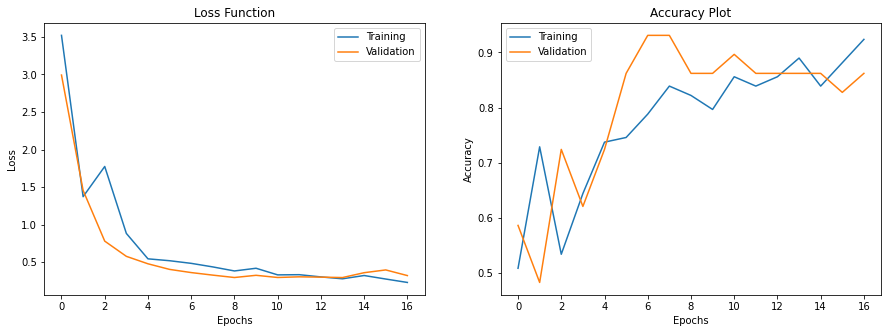

In [9]:
if __name__ == "__main__": 
  main()